## Exercise 1 - Bayes classification system

In [45]:
# Import some useful libraries
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

## 1a. Getting started with Bayes

a) Read the training data from file ex1-data-train.csv. The first two columns are x1 and x2. The last column holds the class label y.

In [46]:
def read_data(file):
    dataset = pd.read_csv(file, names=['x1','x2','y'])
    print(dataset.head())
    return dataset[["x1", "x2"]], dataset["y"].values

In [47]:
X_train, y_train = read_data("ex1-data-train.csv")

          x1         x2  y
0  34.623660  78.024693  0
1  30.286711  43.894998  0
2  35.847409  72.902198  0
3  60.182599  86.308552  1
4  79.032736  75.344376  1


In [48]:
# Prepare a function to compute accuracy
def accuracy_score(y_true, y_pred):
    return (y_true == y_pred).sum() / y_true.size

b) Compute the priors of both classes P(C0) and P(C1)

In [49]:
# TODO: Compute the priors
p_c0 = np.sum(y_train == 0) / y_train.size
p_c1 = np.sum(y_train == 1) / y_train.size

print("P(C0) = ", p_c0)
print("P(C1) = ", p_c1)

P(C0) =  0.4
P(C1) =  0.6


c) Compute histograms of x1 and x2 for each class (total of 4 histograms). Plot these histograms. Advice : use the numpy `histogram(a, bins="auto")` function.

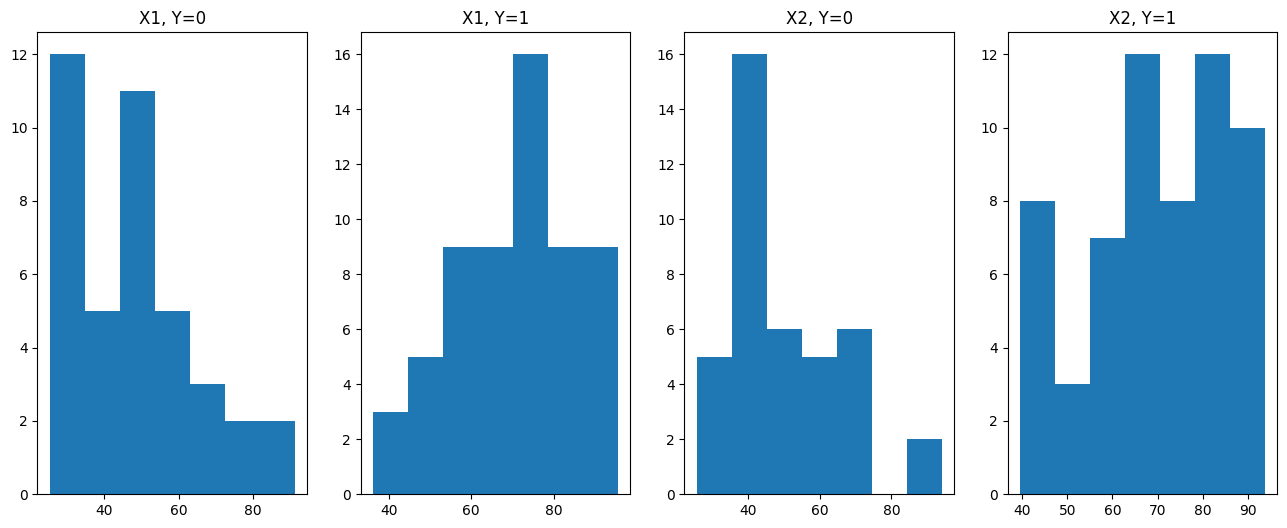

In [50]:
# TODO: Compute histograms from X_train for each class
histograms = [
    np.histogram(X_train[y_train == 0]["x1"], bins='auto'),
    np.histogram(X_train[y_train == 1]["x1"], bins='auto'),
    np.histogram(X_train[y_train == 0]["x2"], bins='auto'),
    np.histogram(X_train[y_train == 1]["x2"], bins='auto')
]

# TODO: plot all histograms
plt.figure(figsize=(16,6))

for i, (hist, bins) in enumerate(histograms):
    plt.subplot(1, 4, i + 1)
    plt.bar(bins[:-1], hist, width = bins[1] - bins[0])
    plt.title(f'X{i // 2 + 1}, Y={i % 2}')

plt.show()

d) Use the histograms to compute the likelihoods p(x1|C0), p(x1|C1), p(x2|C0) and p(x2|C1). For this define a function `likelihood_hist(x, hist_values, edge_values)` that returns the likelihood of x for a given histogram (defined by its values and bin edges as returned by the numpy `histogram()` function).

In [51]:
def likelihood_hist(x: float, hist_values: np.ndarray, bin_edges: np.ndarray) -> float:
   """
   Compute the likelihood of a value given a histogram
   :param x: the value
   :param hist_values: the values of the histogram
   :param bin_edges: the bin edges of the histogram

   :return: the likelihood of the value given the histogram
   """
      # compute the bin width (assume uniform bins)
   bin_width = bin_edges[1] - bin_edges[0]
   # compute the bin index of the value x
   bin_index = np.digitize(x, bin_edges) - 1
   # compute the sum of all histogram values considering the bin width
   total = 0
   for i in range(len(hist_values)):
      total += hist_values[i] * bin_width
   # return the probability of the bin
   return hist_values[bin_index] * bin_width / total

e) Implement the classification decision according to Bayes rule and compute the overall accuracy of the system on the test set ex1-data-test.csv. :
- using only feature x1
- using only feature x2
- using x1 and x2 making the naive Bayes hypothesis of feature independence, i.e. p(X|Ck) = p(x1|Ck) · p(x2|Ck)

In [52]:
X_test, y_test = read_data("ex1-data-test.csv")

          x1         x2  y
0  39.196334  78.530294  0
1  40.448499  86.839470  1
2  65.571920  44.303497  0
3  79.648113  70.806564  1
4  66.260221  41.672703  0


In [53]:
# Computation of the accuracy on the test set using only x1 feature

y_pred = []
for x1 in X_test["x1"]:
    p_x1_c0 = likelihood_hist(x1, histograms[0][0], histograms[0][1][:-1])
    p_x1_c1 = likelihood_hist(x1, histograms[1][0], histograms[1][1][:-1])
    p_c0_x1 = p_x1_c0 * p_c0 / (p_x1_c0 * p_c0 + p_x1_c1 * p_c1)
    y_pred.append(0 if p_c0_x1 > 0.5 else 1)

print("Accuracy on test set (x1 only): ", accuracy_score(y_test, y_pred))

Accuracy on test set (x1 only):  0.66


In [54]:
# Computation of the accuracy on the test set using only x2 feature

y_pred = []
for x in X_test["x2"]:
    p_x2_c0 = likelihood_hist(x, histograms[2][0], histograms[2][1][:-1])
    p_x2_c1 = likelihood_hist(x, histograms[3][0], histograms[3][1][:-1])
    p_c0_x2 = p_x2_c0 * p_c0 / (p_x2_c0 * p_c0 + p_x2_c1 * p_c1)
    y_pred.append(0 if p_c0_x2 > 0.5 else 1)

print("Accuracy on test set (x2 only): ", accuracy_score(y_test, y_pred))

Accuracy on test set (x2 only):  0.61


In [55]:
# Computation of the accuracy on the test set using both x1 and x2 features

y_pred = []
for x1, x2 in zip(X_test["x1"], X_test["x2"]):
    p_x1_c0 = likelihood_hist(x1, histograms[0][0], histograms[0][1][:-1])
    p_x1_c1 = likelihood_hist(x1, histograms[1][0], histograms[1][1][:-1])
    p_x2_c0 = likelihood_hist(x2, histograms[2][0], histograms[2][1][:-1])
    p_x2_c1 = likelihood_hist(x2, histograms[3][0], histograms[3][1][:-1])
    p_c0_x1x2 = p_x1_c0 * p_x2_c0 * p_c0 / (p_x1_c0 * p_x2_c0 * p_c0 + p_x1_c1 * p_x2_c1 * p_c1)
    y_pred.append(0 if p_c0_x1x2 > 0.5 else 1)

print("Accuracy on test set (x1 and x2): ", accuracy_score(y_test, y_pred))

Accuracy on test set (x1 and x2):  0.68


Which system is the best ?

The best system is the one with the highest accuracy. In this case, the best system is the one using both features. But we can see that the system using only x1 is almost as good as the one using both features.

## 1b. Bayes - Univariate Gaussian distribution

Do the same as in a) but this time using univariate Gaussian distribution to model the likelihoods p(x1|C0), p(x1|C1), p(x2|C0) and p(x2|C1). You may use the numpy functions `mean()` and `var()` to compute the mean μ and variance σ2 of the distribution. To model the likelihood of both features, you may also do the naive Bayes hypothesis of feature independence, i.e. p(X|Ck) = p(x1|Ck) · p(x2|Ck).


In [56]:
def likelihood_univariate_gaussian(x: float, mean: float, var: float) -> float:
    return 1 / math.sqrt(2 * math.pi * var) * math.exp(- (x - mean) ** 2 / (2 * var))

In [57]:
# TODO: Compute mean and variance for each classes and each features (8 values)
means = [
    np.mean(X_train[y_train == 0]["x1"]),
    np.mean(X_train[y_train == 0]["x2"]),
    np.mean(X_train[y_train == 1]["x1"]),
    np.mean(X_train[y_train == 1]["x2"])
]

variances = [
   np.var(X_train[y_train == 0]["x1"]),
   np.var(X_train[y_train == 0]["x2"]),
   np.var(X_train[y_train == 1]["x1"]),
   np.var(X_train[y_train == 1]["x2"])
]


In [58]:
likelihood_univariate_gaussian(0.5, means[0], variances[0])

0.00027650980119143533

In [59]:
# TODO: predict on test set in the 3 cases

y_pred = []

for x1, x2 in zip(X_test["x1"], X_test["x2"]):
      p_x_c0 = likelihood_univariate_gaussian(x1, means[0], variances[0]) * likelihood_univariate_gaussian(x2, means[1], variances[1]) * p_c0
      p_x_c1 = likelihood_univariate_gaussian(x1, means[2], variances[2]) * likelihood_univariate_gaussian(x2, means[3], variances[3]) * p_c1
      y_pred.append(0 if p_x_c0 > p_x_c1 else 1)

accuracy_score(y_test, y_pred)

0.89